In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow import keras as kr
from tensorflow.keras import optimizers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Concatenate
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

In [2]:
# upload
print('Uploading...')
exp_matrix = pd.read_csv('/root/work/multi/stad_exp', index_col=0)
label_surv = pd.read_csv('/root/work/multi/stad_label_surv', index_col=0)
label_t = pd.read_csv('/root/work/multi/stad_label_type', index_col=0)
print('Uploading done!')

Uploading...
Uploading done!


In [3]:
# data preprocessing
x = exp_matrix.T

# str -> int
y1 = np.array(label_surv['survival_label'].map({'LTS':0, 'STS':1}).astype(int)).reshape(label_surv.shape[0],1)
y2 = np.array(label_t['Molecular.Subtype'].map({'CIN':0, 'GS':1, 'MSI':2, 'EBV':3}).astype(int))

# int -> onthot
y2 = kr.utils.to_categorical(y2)

In [4]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title(train)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [4]:
train_x, test_x, train_y1, test_y1, train_y2, test_y2 = train_test_split(x, y1, y2, test_size=0.3, random_state=np.random.seed())
print(train_x.shape, test_x.shape, train_y1.shape, test_y1.shape, train_y2.shape, test_y2.shape)

(142, 12411) (61, 12411) (142, 1) (61, 1) (142, 4) (61, 4)


In [14]:
model = Sequential()

#input
input_layer = Input((train_x.shape[1],), name='input')

dense_01 = Dense(8192, kernel_initializer='uniform', activation='LeakyReLU', name='dense_01')(input_layer)
# dropout_01 = Dropout(0.1, name='dropout_01')(dense_01)
dense_02 = Dense(4096,kernel_initializer='uniform',activation='relu', name='dense_02')(dense_01)

#surv
concat_surv = Concatenate(name='concat_surv')([dense_02, input_layer])
dense_11 = Dense(128, kernel_initializer='uniform', activation='relu', name='dense_11')(concat_surv)
dropout_11 = Dropout(0.1, name='dropout_11')(dense_11)
dense_12 = Dense(32, kernel_initializer='uniform', activation='relu', name='dense_12')(dropout_11)
#dropout_12 = Dropout(0.1, name='dropout_12')(dense_12)
outputs_1 = Dense(1,kernel_initializer='uniform',activation='sigmoid', name='output_1')(dense_12)

# #subtype
concat_sub = Concatenate(name='dense_21')([dense_02, input_layer])
dense_21 = Dense(1024, kernel_initializer='uniform', activation='relu')(concat_sub)
dropout_21 = Dropout(0.1, name='dropout_21')(dense_21)
dense_22 = Dense(128, kernel_initializer='uniform', activation='relu', name='dense_22')(dropout_21)
dropout_22 = Dropout(0.1, name='dropout_22')(dense_22)
outputs_2 = Dense(4,kernel_initializer='uniform',activation='softmax', name='output_2')(dropout_22)

model = Model(inputs=input_layer, outputs=[outputs_1, outputs_2], name='conbinedModel')

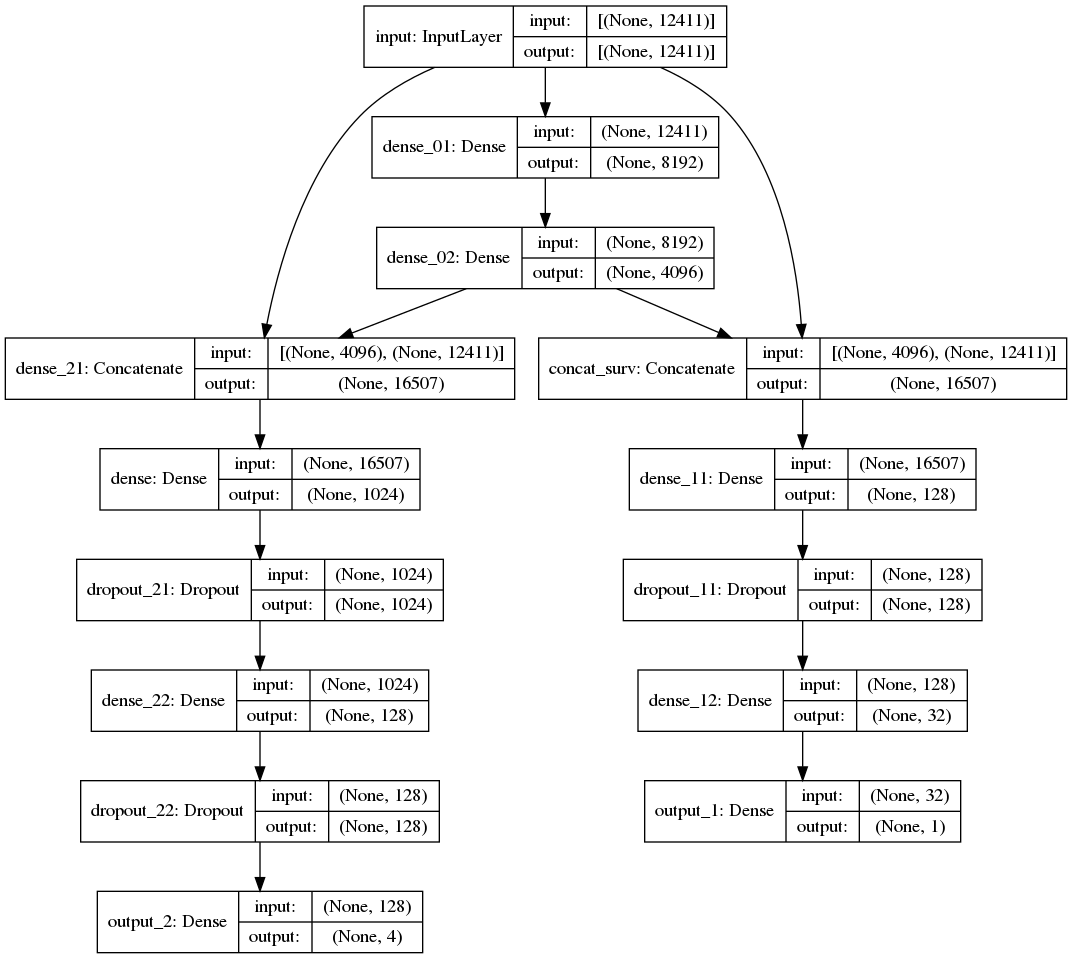

In [15]:
plot_model(model, show_shapes=True)

In [16]:
model.compile(loss={'output_1':kr.losses.BinaryCrossentropy(), 'output_2':kr.losses.CategoricalCrossentropy()},
              loss_weights={'output_1':0.7, 'output_2':0.3},
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
b = 32
train_history=model.fit(train_x,
                        {'output_1':train_y1,'output_2':train_y2},
                        epochs=30,
                        validation_split=0.1,
                        batch_size=b)

Epoch 1/30
4/4 [==============================] - 2s 321ms/step - loss: 5.5335 - output_1_loss: 1.2902 - output_2_loss: 15.4346 - output_1_accuracy: 0.6457 - output_2_accuracy: 0.3858 - val_loss: 2.1884 - val_output_1_loss: 0.8012 - val_output_2_loss: 5.4252 - val_output_1_accuracy: 0.8000 - val_output_2_accuracy: 0.5333
Epoch 2/30
4/4 [==============================] - 1s 224ms/step - loss: 2.1836 - output_1_loss: 0.7249 - output_2_loss: 5.5873 - output_1_accuracy: 0.7402 - output_2_accuracy: 0.4961 - val_loss: 1.6040 - val_output_1_loss: 0.6174 - val_output_2_loss: 3.9060 - val_output_1_accuracy: 0.8000 - val_output_2_accuracy: 0.6000
Epoch 3/30
4/4 [==============================] - 1s 235ms/step - loss: 2.0096 - output_1_loss: 0.5856 - output_2_loss: 5.3324 - output_1_accuracy: 0.7874 - output_2_accuracy: 0.5591 - val_loss: 1.0067 - val_output_1_loss: 0.5642 - val_output_2_loss: 2.0390 - val_output_1_accuracy: 0.9333 - val_output_2_accuracy: 0.6667
Epoch 4/30
4/4 [=================

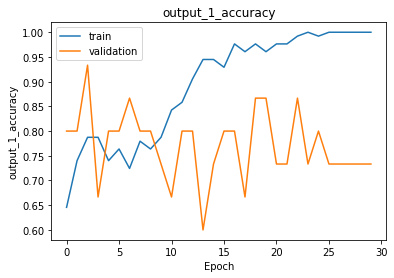

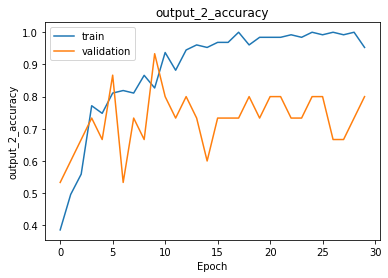

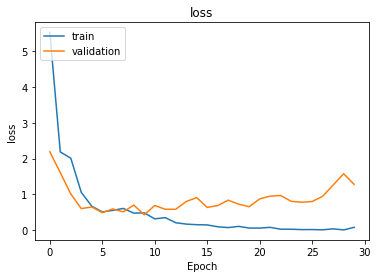

In [18]:
show_train_history(train_history, 'output_1_accuracy', 'val_output_1_accuracy')
show_train_history(train_history, 'output_2_accuracy', 'val_output_2_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [19]:
loss1, loss1_1, loss1_2,  accuracy1_1, accuracy1_2 = model.evaluate(x=test_x, y=[test_y1, test_y2])

2/2 [==============================] - 0s 31ms/step - loss: 1.9359 - output_1_loss: 2.1472 - output_2_loss: 1.4430 - output_1_accuracy: 0.6721 - output_2_accuracy: 0.8197


In [119]:
model_surv.evaluate(test_x, test_y1)
model_sub.evaluate(test_x, test_y2)

2/2 [==============================] - 0s 5ms/step - loss: 0.5706 - categorical_accuracy: 0.9508


[0.5706142783164978, 0.9508196711540222]

In [5]:
from keras.models import load_model

# # 保存训练好的model为hdf5文件
# model.save('/root/work/model/stad_multi_model.h5')  
# 重新加载模型
model_m = load_model('/root/work/model/stad_multi_model.h5')

model_surv = load_model('/root/work/model/stad_surv_model.h5')
model_sub = load_model('/root/work/model/stad_subtype_model.h5')

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = test_y1
y_pred = model.predict(test_x)[0].astype(np.int64)
cm = confusion_matrix(y_true,y_pred)
cm = pd.DataFrame(cm, columns=['LTS','STS'], index=['LTS','STS'])
cm

NameError: name 'model' is not defined

In [58]:
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(formatter={"float": "{: 0.2f}".format})
cm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


,LTS,STS
LTS,0.953488,0.046512
STS,0.944444,0.055556


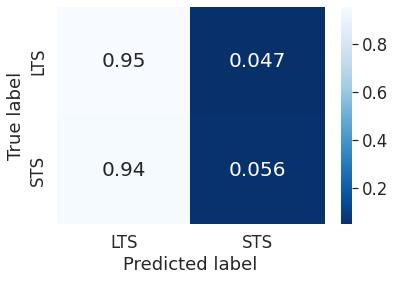

In [59]:
sns.set(font_scale=1.5)
plt.rc('font',size=20)
sns.heatmap(cm,cmap="Blues_r",annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
y_true = np.argmax(test_y2, axis=-1).reshape(test_y2.shape[0],1)
y_pred = np.argmax(model_m.predict(test_x)[1].astype(np.int64), axis=-1).reshape(test_y2.shape[0],1)
cm = confusion_matrix(y_true,y_pred)
cm = pd.DataFrame(cm, columns=['CIN', 'GS', 'MSI', 'EBV'], index=['CIN', 'GS', 'MSI', 'EBV'])
cm

,CIN,GS,MSI,EBV
CIN,30,0,0,0
GS,10,2,0,0
MSI,8,0,7,0
EBV,2,0,0,2


In [13]:
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(formatter={"float": "{: 0.3f}".format})
cm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


,CIN,GS,MSI,EBV
CIN,1.000000,0.000000,0.000000,0.0
GS,0.833333,0.166667,0.000000,0.0
MSI,0.533333,0.000000,0.466667,0.0
EBV,0.500000,0.000000,0.000000,0.5


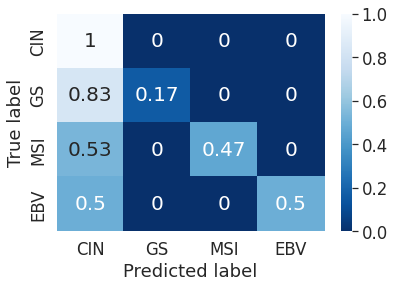

In [14]:
sns.set(font_scale=1.5)
plt.rc('font',size=20)
sns.heatmap(cm,cmap="Blues_r",annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
m_surv = []
m_sub = []
surv = []
sub = []
for i in range(10):
    train_x, test_x, train_y1, test_y1, train_y2, test_y2 = train_test_split(x, y1, y2, test_size=0.3, random_state=np.random.seed())

    loss1, loss1_1, loss1_2,  accuracy1_1, accuracy1_2 = model.evaluate(x=test_x, y=[test_y1, test_y2])
    loss2, accuracy2 = model_surv.evaluate(test_x, test_y1)
    loss3, accuracy3 = model_sub.evaluate(test_x, test_y2)
    m_surv.append(accuracy1_1)
    surv.append(accuracy2)
    m_sub.append(accuracy1_2)
    sub.append(accuracy3)

evaluate_result = pd.DataFrame([m_surv, surv, m_sub, sub], index=['m_surv','surv', 'm_sub', 'sub'])
evaluate_result

In [12]:
import tensorflow as tf
import keras.backend as K
def Precision(model,test_x,test_y):
    y_pred = model.predict(test_x)
    y_pred = np.argmax(y_pred.reshape(y_pred.shape[0],1), axis=-1)
    tp = K.sum(K.round(K.clip(test_y * y_pred, 0, 1)))  # true positives
    tp = tf.cast(tp,dtype=tf.float64)
    pp = K.sum(K.round(K.clip(y_pred, 0, 1)))  # predicted positives
    pp = tf.cast(pp,dtype=tf.float64)
    precision = tp / (pp + K.epsilon())
    return precision

def Recall(model,test_x,test_y):
    y_pred = model.predict(test_x)
    y_pred = np.argmax(y_pred, axis=-1)
    tp = K.sum(K.round(K.clip(test_y * y_pred, 0, 1)))  # true positives
    tp = tf.cast(tp,dtype=tf.float64)
    pp = K.sum(K.round(K.clip(test_y, 0, 1)))  # possible positives
    pp = tf.cast(pp,dtype=tf.float64)
    recall = tp / (pp + K.epsilon())
    return recall

def F1(model,test_x,test_y):
    precision = Precision(model,test_x,test_y)
    recall = Recall(model,test_x,test_y)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

In [13]:
Precision(model_m,test_x,test_y1).numpy()

AttributeError: 'list' object has no attribute 'reshape'

In [8]:
m_surv = []
m_sub = []
surv = []
sub = []
for i in range(10):
    train_x, test_x, train_y1, test_y1, train_y2, test_y2 = train_test_split(x, y1, y2, test_size=0.3, random_state=np.random.seed())

    m_surv.append(Precision(model_m,test_x,test_y1).numpy())
    surv.append(Precision(model_surv,test_x,test_y1).numpy())
    m_sub.append(Precision(model_m,test_x,test_y2).numpy())
    sub.append(Precision(model_sub,test_x,test_y2).numpy())

evaluate_result = pd.DataFrame([m_surv, surv, m_sub, sub], index=['m_surv','surv', 'm_sub', 'sub'])
evaluate_result

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: could not broadcast input array from shape (61,1) into shape (61)

In [18]:
import tensorflow as tf
def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[1][:, top_pred_idx]  # surv: preds[0], sub: preds[1]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # # 2. Preprocess the interpolated images
    # interpolated_image = xception.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

In [ ]:
# surv
x = np.array(test_x.iloc[0])
img_size = x.shape
top_k = int(len(x)/100)

for num in range(len(test_x)):
    print(num)
    s = np.array(test_x.iloc[num]).reshape(1,test_x.shape[1])
    x = np.array(test_x.iloc[num])
    preds = model.predict(s)

    top_pred_idx = tf.argmax(preds[0][0])
    igrads = random_baseline_integrated_gradients(np.copy(x), top_pred_idx=top_pred_idx, num_steps=50, num_runs=2)
    igrads = np.array(igrads).reshape(1,test_x.shape[1])

    if num == 0:
        igs = igrads
    else:
        igs = np.concatenate((igs, igrads), axis=0)

In [14]:
preds = model.predict(test_x)[0]
preds_y = pd.DataFrame(np.where(preds>0.5, 1, 0), columns=['class'])

idx_0 = preds_y.index[preds_y['class']==0].to_list()
idx_1 = preds_y.index[preds_y['class']==1].to_list()

igs = pd.DataFrame(igs, columns=test_x.columns)

surv_0 = igs.loc[idx_0]
surv_1 = igs.loc[idx_1]

In [17]:
# LTS
row_mean = pd.DataFrame(surv_0.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/stad_multi_surv0_igs_mean')

# STS
row_mean = pd.DataFrame(surv_1.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/stad_multi_surv1_igs_mean')

In [25]:
# sub
x = np.array(test_x.iloc[0])
img_size = x.shape
top_k = int(len(x)/100)

for num in range(len(test_x)):
    print(num)
    s = np.array(test_x.iloc[num]).reshape(1,test_x.shape[1])
    x = np.array(test_x.iloc[num])
    preds = model.predict(s)

    top_pred_idx = tf.argmax(preds[1][0])
    igrads = random_baseline_integrated_gradients(np.copy(x), top_pred_idx=top_pred_idx, num_steps=50, num_runs=2)
    igrads = np.array(igrads).reshape(1,test_x.shape[1])

    if num == 0:
        igs = igrads
    else:
        igs = np.concatenate((igs, igrads), axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [26]:
preds = model.predict(test_x)[1]
preds = np.argmax(preds, axis=1)
preds_y = pd.DataFrame(preds, columns=['class'])

idx_0 = preds_y.index[preds_y['class']==0].to_list()
idx_1 = preds_y.index[preds_y['class']==1].to_list()
idx_2 = preds_y.index[preds_y['class']==2].to_list()
idx_3 = preds_y.index[preds_y['class']==3].to_list()

igs = pd.DataFrame(igs, columns=test_x.columns)

sub_0 = igs.loc[idx_0]
sub_1 = igs.loc[idx_1]
sub_2 = igs.loc[idx_2]
sub_3 = igs.loc[idx_3]

In [28]:
# CIN
row_mean = pd.DataFrame(sub_0.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/stad_multi_sub0_igs_mean')

# GS
row_mean = pd.DataFrame(sub_1.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/stad_multi_sub1_igs_mean')

# MSI
row_mean = pd.DataFrame(sub_2.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/stad_multi_sub2_igs_mean')

# EBV
row_mean = pd.DataFrame(sub_3.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/stad_multi_sub3_igs_mean')